custom: pca__percent_variance=0.75
custom: kmeans__n_clusters=2
**************************************************
Model Selection Streamline: svr --> lr --> knnr --> lasso --> abr --> mlpr
**************************************************
Constructed SupportVectorRegressorPredictiveModel: svr
Constructed LinearRegressorPredictiveModel: lr
Constructed KNeighborsRegressorRegressorPredictiveModel: knnr
Constructed LassoRegressorPredictiveModel: lasso
Constructed AdaptiveBoostingRegressorPredictiveModel: abr
Constructed MultilayerPerceptronRegressor: mlpr
**************************************************
Determining Best Estimators.
**************************************************
Returning svr best estiminator
Returning lr best estiminator
Returning knnr best estiminator
Returning lasso best estiminator
Returning abr best estiminator
Returning mlpr best estiminator
**************************************************
Regressor Performance Sheet
*****************************************

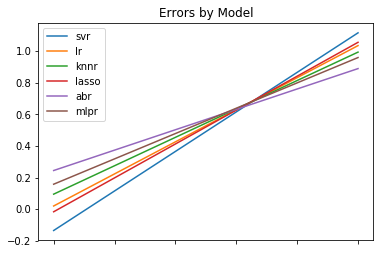

{'svr': SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False), 'lr': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), 'knnr': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=9, p=2,
          weights='uniform'), 'lasso': Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), 'abr': AdaBoostRegressor(base_estimator=None, learning_rate=0.1, loss='linear',
         n_estimators=20, random_state=None), 'mlpr': MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
    

In [10]:

import pandas as pd
import numpy as np
import sys
sys.path.append('/Users/laurensuarez/Desktop/streamml')
import warnings
warnings.filterwarnings("ignore")

from streamline.transformation.flow.TransformationStream import TransformationStream
from streamline.model_selection.flow.ModelSelectionStream import ModelSelectionStream

# git checkout -b modelSelectionUpdates
# git push -u origin modelSelectionUpdates

# FOR MAC:
# nano ~/.bash_profile
# export PYTHONPATH="${PYTHONPATH}:/Users/bmc/Desktop/streamml"
# source ~/.bash_profile
# python -W ignore tester.py

X = pd.DataFrame(np.matrix([[np.random.exponential() for j in range(10)] for i in range(200)]))
y = pd.DataFrame(np.array([np.random.exponential() for i in range(200)]))

#D = pd.read_csv("Series3_6.15.17_padel.csv")
#X = D.iloc[:,2:]
#y = D.iloc[:,1]

#ynakiller = y.isna()
#X = X.iloc[-ynakiller,:]
#y = y.iloc[-ynakiller]
#X.replace([np.nan, np.inf, -np.inf],0, inplace=True)

#print(X.shape)
#print (y.shape)

"""
Supported Transformations:
["scale","normalize","boxcox","binarize","pca","kmeans"]
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Binarizer.html
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

To be implemented:
["brbm"] --> Latent representations of the data
http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.BernoulliRBM.html#sklearn.neural_network.BernoulliRBM
"""
Xnew = TransformationStream(X).flow(["scale","normalize","pca", "kmeans"], 
                                    params={"pca__percent_variance":0.75, 
                                            "kmeans__n_clusters":2},
                                   verbose=False)

#preproc options: scale, normalize, boxcox, binarize, pca, kmeans
#model options: 
#error options: 'mean_squared_error','r2'

#scoring option not working right, be okay with default scorers.

"""
Supported Models:
["lr", "ridge", "lasso", "enet", "svr", "knnr", "abr", "rfr", "mlpr"]
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

To be implemented
["lar", "dtr"]
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor

Supported Metrics:
['rmse','mse', 'r2','explained_variance','mean_absolute_error','median_absolute_error']
"""



performances = ModelSelectionStream(Xnew,y).flow(["svr", "lr", "knnr","lasso","abr", "mlpr"],
                                              params={'svr__C':[1,0.1,0.01,0.001],
                                                      'svr__gamma':[0, 0.01, 0.001, 0.0001],
                                                      'svr__kernel':['poly', 'rbf'],
                                                      'svr__epsilon':[0,0.1,0.01,0.001],
                                                     'lr__fit_intercept':[False, True],
                                                     'knnr__n_neighbors':[3, 5,7, 9, 11, 13,15,17,19,21],
                                                     'lasso__alpha':[0,0.01,1,10.0,20.0],
                                                     'abr__n_estimators':[10,20,50],
                                                     'abr__learning_rate':[0.1,1,10, 100]},
                                                metrics=['r2','rmse'],
                                                verbose=True,
                                                regressors=True,
                                                cut=2)
                                                
print(performances)

In [7]:
# TO BE INTEGRATED INTO STREAMML FEATURE SELECTION MODULE

In [ ]:
# Mixed Selection
from statsmodels.regression import linear_model

def mixed_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
                                                      
        best_pval = new_pval.min()
        
        

        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            #best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            #worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))

        if not changed:
            break

    
    return included

In [ ]:
# Lasso
# (Feature_Space_3) Lasso Coeficients > 0 

lasso_pipe             = Pipeline([('lasso',Lasso())])
lasso_param_grid       = {'lasso__alpha':[0.01, 0.1, 1, 10, 100]}
lasso_grid             = GridSearchCV(lasso_pipe, param_grid=lasso_param_grid, cv=3, n_jobs=4, verbose=True)
lasso_fit              = lasso_grid.fit(Xtrain,bigframe_train.IC50).best_estimator_.named_steps["lasso"]
lasso_features         = lasso_fit.coef_
lasso_features         = bigframe.columns[abs(lasso_fit.coef_) > 0].tolist()
lasso_features_size    = len(lasso_features)
lasso_features

In [ ]:
# Random Forest
# (Feature_Space_4) Feature Importance > 0 

rf_pipe              = Pipeline([('rf',RandomForestClassifier())])
rf_param_grid       = {'rf__n_estimators':[10,100],
                       'rf__bootstrap':[True, False],
                       'rf__criterion':['gini','entropy']}

rf_grid             = GridSearchCV(rf_pipe, param_grid=rf_param_grid, n_jobs=4, cv=3, verbose=True)

rf_fit              = rf_grid.fit(Xtrain,ytrain).best_estimator_.named_steps['rf']
rf_features         = rf_fit.feature_importances_
rf_features         = bigframe.columns[rf_features > 0].tolist()
rf_features_size    = len(rf_features)
rf_features


In [ ]:
#MADM
from skcriteria import Data, MIN, MAX
from skcriteria.madm import closeness, simple

# (Feature_Space_5) TOPSIS Top K Ranked Features

feat_df = pd.DataFrame({'RF_Classifier':rf_fit.feature_importances_,
                        'LASSO_Coef':abs(lasso_fit.coef_)},
                      index=bigframe.columns[3:].tolist())

mtx = feat_df.as_matrix()
mtx

# let's says the first two alternatives are
# for maximization and the last one for minimization
criteria = [MAX, MAX]
criteria

data = Data(mtx, criteria,
            weights=[0.5,0.5],
            anames=feat_df.index.tolist(),
            cnames=feat_df.columns)

dm1 = simple.WeightedSum()
dm2 = simple.WeightedProduct()
dm3 = closeness.TOPSIS(mnorm="vector")
dm4 = closeness.TOPSIS(mnorm="sum")

ranks=[]
for alg in [dm1, dm2, dm3, dm4]:
    dec = alg.decide(data)
    ranks.append(dec.rank_) 
# Now lets decide the ranking

rank_matrix= pd.DataFrame(ranks, index=['WeightedSum',
                                     'WeightedProduct',
                                     'TOPSIS_VectorNormalized',
                                     'TOPSIS_SumNormalized'],
                                   columns=feat_df.index).T

rank_matrix

rank_mask = rank_matrix < max([  len(rf_features),
                                 len(lasso_features),
                                 len(mixed_selection_features),
                                 len(mixed_selection_1x_features)])

rank_matrix=rank_matrix.loc[(rank_mask).any(axis=1)]

topsis_features = rank_matrix.index.tolist()
topsis_features_size = len(topsis_features)




In [ ]:
# Get subspace features
data_per_space = {}
def get_train_test_in_space(bigframe_train, bigframe_test, space):

    bigframe_train = shuffle(bigframe_train, random_state=0)
    bigframe_test = shuffle(bigframe_test, random_state=0)
    
    ytrain = bigframe_train["bin2"].as_matrix()
    Xtrain = StandardScaler().fit_transform(bigframe_train[space].as_matrix())

    ytest = bigframe_test["bin2"].as_matrix()
    Xtest = StandardScaler().fit_transform(bigframe_test[space].as_matrix())
    print("Data ready to model.")
    
    return Xtrain, ytrain, Xtest, ytest

for k,space in feature_space.items():
    data_per_space[k]=get_train_test_in_space(bigframe_train, bigframe_test, space)

In [ ]:
# Confidence Intervals
import numpy as np
import scipy as sp
import scipy.stats

full_confidence_intervals={}
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m-h, m+h

for k,v in full_scores.items():
    
    full_confidence_intervals[k] = mean_confidence_interval(v)

In [ ]:
# Visualize Confidence Intervals
import matplotlib
font = {'family' : 'normal',
  'weight' : 'bold',
  'size' : 16}
matplotlib.rc('font', **font)
ax=sns.boxplot(x="AUC", y="Model", data=pd.melt(pd.DataFrame(full_confidence_intervals), var_name='Model', value_name='AUC'))    
plt.title('ROC AUC ML Model')
plt.show()
# Add legend Add title Change Axis

['',
 '/Users/laurensuarez/anaconda3/lib/python36.zip',
 '/Users/laurensuarez/anaconda3/lib/python3.6',
 '/Users/laurensuarez/anaconda3/lib/python3.6/lib-dynload',
 '/Users/laurensuarez/anaconda3/lib/python3.6/site-packages',
 '/Users/laurensuarez/anaconda3/lib/python3.6/site-packages/aeosa',
 '/Users/laurensuarez/anaconda3/lib/python3.6/site-packages/IPython/extensions',
 '/Users/laurensuarez/.ipython']